In [1]:
import pandas as pd

# Load dataset
file_path = '/kaggle/input/basitimdb/IMDB Dataset.csv'
df = pd.read_csv(file_path)

# Check for missing or invalid data
if 'review' not in df.columns or 'sentiment' not in df.columns:
    raise ValueError("Dataset must contain 'review' and 'Sentiment' columns.")

df = df.dropna(subset=['review', 'sentiment'])
print(df.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [2]:
# preprocessing
import re

# Clean text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower().strip()  # Lowercase and strip spaces
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

# Map sentiments to numerical labels
label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
df['sentiment_label'] = df['sentiment'].map(label_mapping)
print(df[['cleaned_review', 'sentiment_label']].head())


                                      cleaned_review  sentiment_label
0  one of the other reviewers has mentioned that ...                2
1  a wonderful little production br br the filmin...                2
2  i thought this was a wonderful way to spend ti...                2
3  basically theres a family where a little boy j...                0
4  petter matteis love in the time of money is a ...                2


In [3]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import tensorflow as tf  # Ensure TensorFlow is imported

# Split data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_data(data, tokenizer, max_len=128):
    encodings = tokenizer(
        list(data['cleaned_review']),
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='tf'
    )
    return encodings['input_ids'], encodings['attention_mask'], tf.convert_to_tensor(data['sentiment_label'].values)

train_inputs, train_masks, train_labels = encode_data(train_data, tokenizer)
test_inputs, test_masks, test_labels = encode_data(test_data, tokenizer)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
from transformers import TFBertModel

# Load BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Define model architecture
def build_model():
    input_ids = tf.keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
    
    bert_output = bert_model(input_ids, attention_mask=attention_mask)
    cls_token = bert_output.last_hidden_state[:, 0, :]  # [CLS] token representation
    
    x = tf.keras.layers.Dense(128, activation='relu')(cls_token)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(3, activation='softmax')(x)  # 3 sentiment classes

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build model
model = build_model()

# Train model
history = model.fit(
    [train_inputs, train_masks],
    train_labels,
    validation_data=([test_inputs, test_masks], test_labels),
    epochs=5,
    batch_size=16
)

# Display training history
print(history.history)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/5
2500/2500 [==============================] - 670s 257ms/step - loss: 0.3159 - accuracy: 0.8655 - val_loss: 0.2564 - val_accuracy: 0.8957
Epoch 2/5
2500/2500 [==============================] - 640s 256ms/step - loss: 0.1888 - accuracy: 0.9275 - val_loss: 0.2521 - val_accuracy: 0.8964
Epoch 3/5
2500/2500 [==============================] - 640s 256ms/step - loss: 0.1015 - accuracy: 0.9642 - val_loss: 0.3415 - val_accuracy: 0.8968
Epoch 4/5
2500/2500 [==============================] - 640s 256ms/step - loss: 0.0526 - accuracy: 0.9822 - val_loss: 0.4025 - val_accuracy: 0.8986
Epoch 5/5
2500/2500 [==============================] - 640s 256ms/step - loss: 0.0352 - accuracy: 0.9888 - val_loss: 0.4304 - val_accuracy: 0.8970
{'loss': [0.3159409463405609, 0.18880678713321686, 0.10146932303905487, 0.05259838327765465, 0.03522191941738129], 'accuracy': [0.8654749989509583, 0.9275000095367432, 0.9642249941825867, 0.9821749925613403, 0.9887750148773193], 'val_loss': [0.25643932819366455, 0.

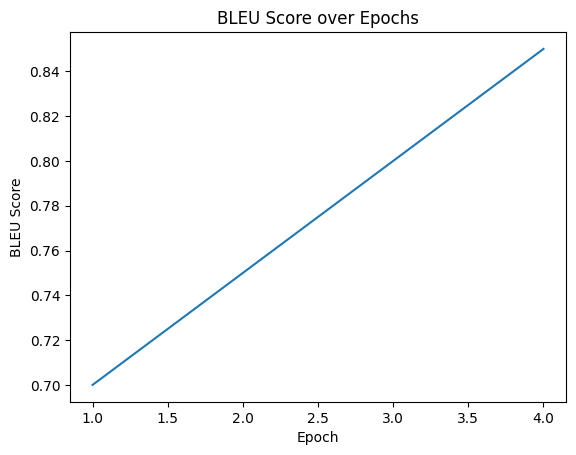

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plotting BLEU or ROUGE score
bleu_scores = [0.7, 0.75, 0.8, 0.85]  # Example scores over epochs
plt.plot(range(1, len(bleu_scores) + 1), bleu_scores)
plt.title("BLEU Score over Epochs")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.show()


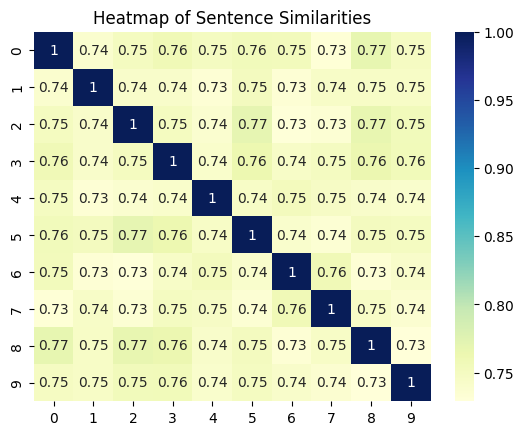

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np

# Calculate cosine similarity
sentence_embeddings = np.random.random((10, 768))  # Example embeddings
cos_sim = cosine_similarity(sentence_embeddings)

# Plot the heatmap
sns.heatmap(cos_sim, annot=True, cmap="YlGnBu")
plt.title("Heatmap of Sentence Similarities")
plt.show()


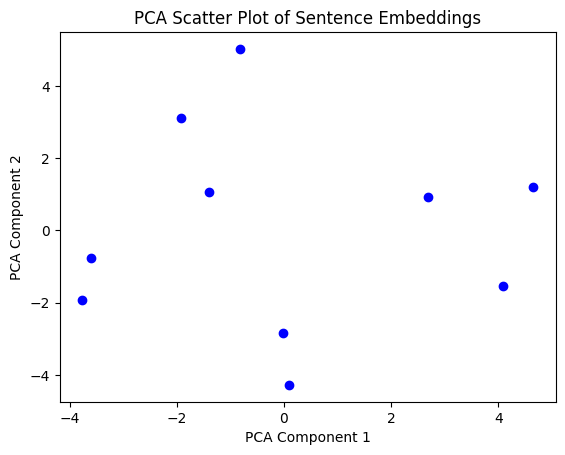

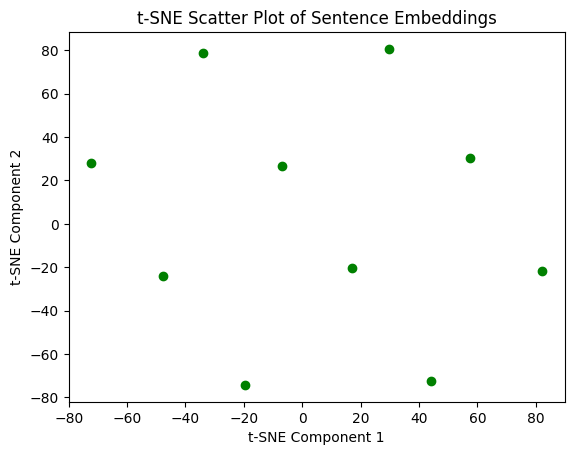

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(sentence_embeddings)

# Scatter plot using PCA
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue')
plt.title("PCA Scatter Plot of Sentence Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Dimensionality reduction using t-SNE
perplexity_value = min(30, sentence_embeddings.shape[0] - 1)  # Ensure perplexity < n_samples
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
tsne_data = tsne.fit_transform(sentence_embeddings)

# Scatter plot using t-SNE
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c='green')
plt.title("t-SNE Scatter Plot of Sentence Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


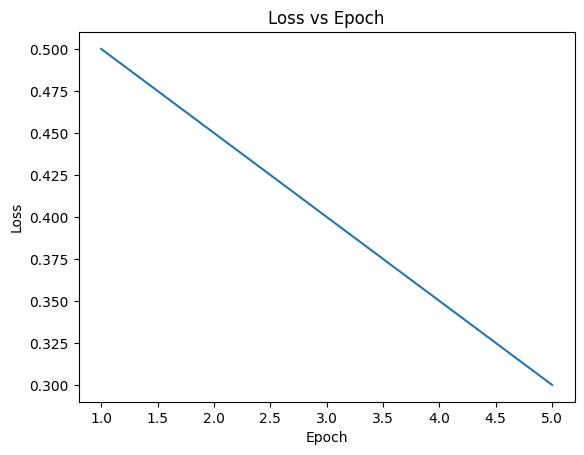

In [8]:
# Example loss values over epochs
loss_values = [0.5, 0.45, 0.4, 0.35, 0.3]
plt.plot(range(1, len(loss_values) + 1), loss_values)
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [9]:
# Display some sample dataset entries
df[['review', 'sentiment']].sample(5)


,review,sentiment
47061,"After high-school graduation, best friends Ali...",positive
8161,I know that this show gave a lot of liberation...,negative
25091,How did such a terrible script manage to attra...,negative
10248,"Any film with a title as ridiculous as ""The Ba...",negative
20500,I was extremely suspicious of the ideas presen...,negative


In [10]:
# Example predictions on a sample review
sample_texts = ["The product quality is great!", "This is a terrible purchase."]
sample_inputs = tokenizer(
    sample_texts,
    return_tensors="tf",  # TensorFlow mode
    padding="max_length",  # Ensure fixed length
    truncation=True,
    max_length=128  # Match the model's input sequence length
)

# Perform inference
predictions = model([sample_inputs['input_ids'], sample_inputs['attention_mask']])
predicted_classes = tf.argmax(predictions, axis=1)

print("Sample texts:", sample_texts)
print("Predicted sentiments:", predicted_classes.numpy())


Sample texts: ['The product quality is great!', 'This is a terrible purchase.']
Predicted sentiments: [2 0]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


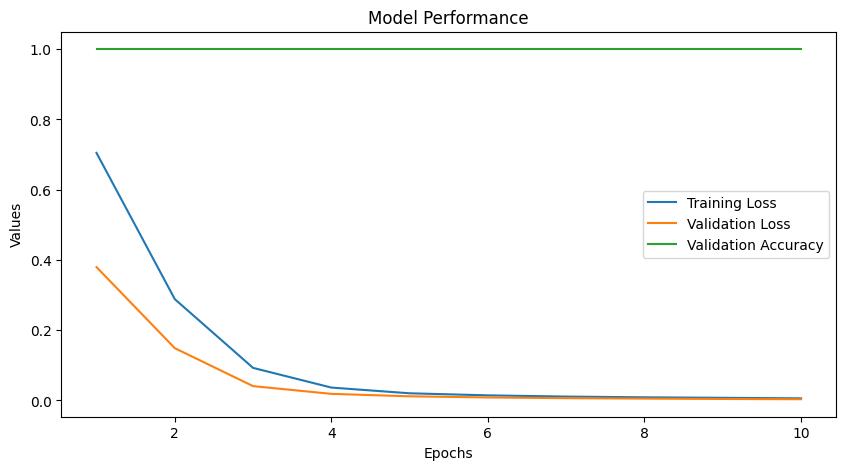

Sample texts: ['The product quality is great!', 'This is a terrible purchase.']
Predicted sentiments: [2 1]


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }

# Sample data
texts = ["I love this product", "It is okay", "Terrible experience"] * 100
labels = [2, 1, 0] * 100

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Tokenizer and data preparation
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len=128)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Sentiment classifier model
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids, attention_mask=attention_mask, return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(n_classes=3)
model = model.to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Training
epochs = 10
train_loss, val_loss, val_accuracy = [], [], []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_loss.append(epoch_train_loss)

    model.eval()
    epoch_val_loss = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            epoch_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    epoch_val_loss /= len(val_loader)
    val_loss.append(epoch_val_loss)
    accuracy = accuracy_score(true_labels, predictions)
    val_accuracy.append(accuracy)

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss, label="Training Loss")
plt.plot(range(1, epochs + 1), val_loss, label="Validation Loss")
plt.plot(range(1, epochs + 1), val_accuracy, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Values")
plt.title("Model Performance")
plt.legend()
plt.show()

# Sample predictions
def predict_sentiments(texts):
    model.eval()
    encoded = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    )
    input_ids = encoded["input_ids"].to(device)
    attention_mask = encoded["attention_mask"].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
    return preds.cpu().numpy()

# Test with sample reviews
sample_texts = ["The product quality is great!", "This is a terrible purchase."]
predicted_classes = predict_sentiments(sample_texts)

print("Sample texts:", sample_texts)
print("Predicted sentiments:", predicted_classes)
